# Self-Driving Car Engineer Nanodegree
## Advanced Lane Finding on the Road

## Goals/Steps

The goals / steps of this project are the following:
* Import packages
* Camera Calibration and Apply a distortion correction to Calibration image.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Run pipeline in a video.

### Import and initialize the packages needed in the project

In [186]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon

from moviepy.editor import VideoFileClip
from IPython.display import HTML

np.random.seed(23)

%matplotlib inline

## 1. Camera Calibration

### 1.1: Compute the camera calibration using chessboard images

In [242]:
def calibrate_camera(images, nx=9, ny=6):
    """"
    images = paths to the images used to calibrate the camera
    nx = Number of inside corners in x
    ny = Number of inside corners in y
    """

    objpoints = []  # Points on the world view
    imgpoints = []  # Points on the Image view

    # Prepare the objpoints (54 points of the world view (x, y, z)
    opts = np.zeros((nx*ny,3), np.float32)
    opts[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Step through the list and search for chessboard corners
    img = None
    for calibration_image in images:    
        # Read the image using matplotlib
        img = mpimg.imread(calibration_image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(opts)  # 54 Points World View Image
            imgpoints.append(corners)  # 54 Points on Camera View Image

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs

# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
    file_name = "./writeup_images/" + title_2.replace(" ", "_") + ".jpg"
    plt.savefig(file_name, dpi = 300, bbox_inches='tight')
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

Camera successfully calibrated.


### 1.2: Apply distortion matrix to un-distort one of the calibration images

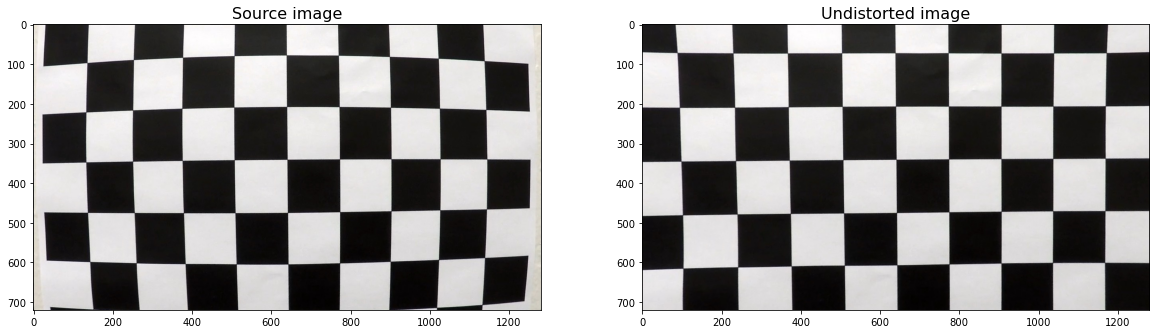

In [243]:
# Undistort a test image
img = mpimg.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

plt_images(img, 'Source image', undistorted_img, 'Undistorted image')

## 2. Pipeline (test images)

### 2.1:  Apply distortion-correction to each test image.

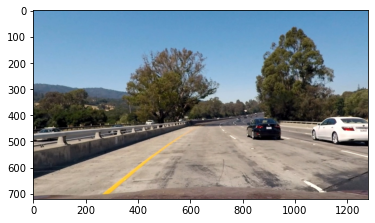

In [244]:
# Load a test image, convert to RGB and undistort it
for test_image in glob.glob('./test_images/test*.jpg'):
    img = mpimg.imread(test_image)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    if "test1.jpg" in test_image:
        plt.imshow(img)
        plt.show()
    output_file = test_image.replace("test_images", "output_images")
    mpimg.imsave(output_file, img)

### 2.2: Use Gradients and color transforms to create a binary image containing likely lane pixels.

#### Step 2.2.1: Sobel gradient in x-direction or y-direction

In [245]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#### Example Thresholded Binary Image - Sobel gradient in x-direction

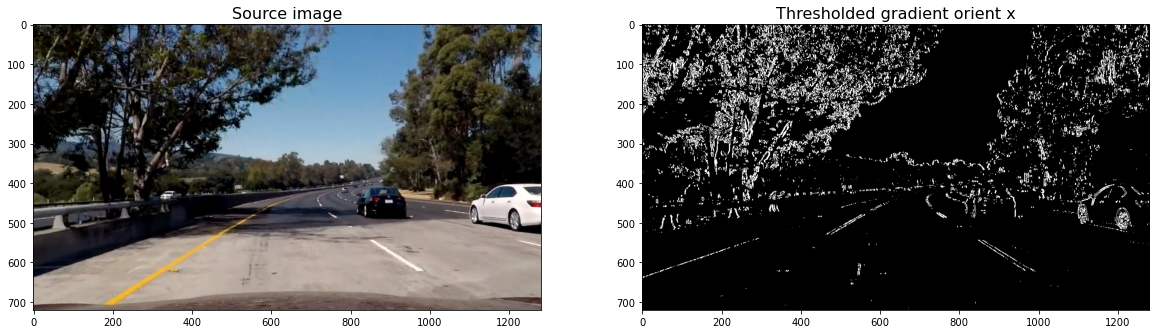

In [246]:
# Run the function
image = mpimg.imread('./test_images/test5.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

grad_x = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=15, thresh=(25, 100))

# Plot the result
plt_images(undistorted, 'Source image', grad_x, 'Thresholded gradient orient x')

#### Example Thresholded Binary Image - Sobel gradient in y-direction

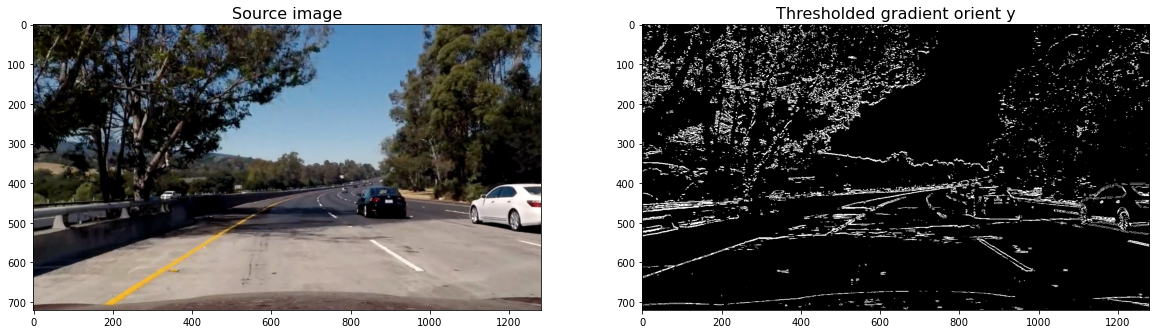

In [247]:
grad_y = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=15, thresh=(30, 100))

# Plot the result
plt_images(undistorted, 'Source image', grad_y, 'Thresholded gradient orient y')

#### Step 2.2.2: Calculate gradient magnitude x-y direction

In [249]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Example Thresholded Binary Image - Gradient Magnitude in x-y direction

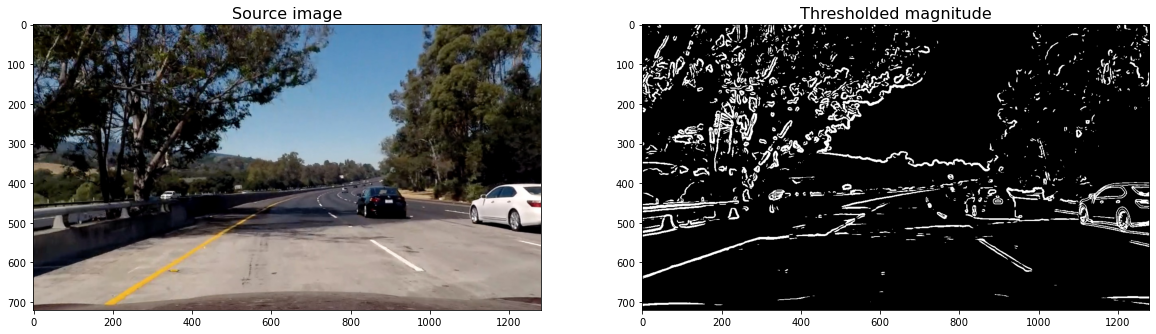

In [250]:
# Run the function
mag_binary = mag_threshold(undistorted, sobel_kernel=15, thresh=(50, 150))

# Plot the result
plt_images(undistorted, 'Source image', mag_binary, 'Thresholded magnitude')

#### Step 2.2.3: Calculate gradient direction

In [251]:
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x_gradient = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y_gradient = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x_gradient = np.absolute(x_gradient)
    abs_y_gradient = np.absolute(y_gradient)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_direction = np.arctan2(abs_y_gradient, abs_x_gradient)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_direction)
    # 6) Return this mask as your binary_output image
    binary_output[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1
    return binary_output

#### Example Thresholded Binary Image - Gradient Direction

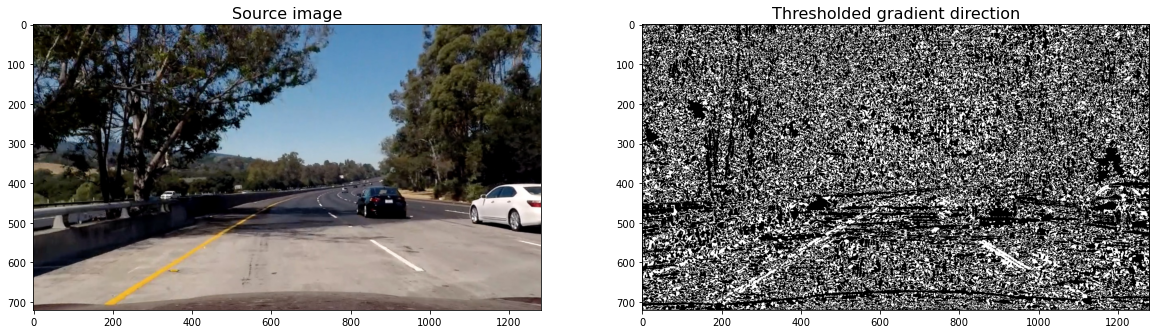

In [252]:
# Run the function
dir_binary = dir_threshold(undistorted, sobel_kernel=9, thresh=(0.7, 1.3))

# Plot the result
plt_images(undistorted, 'Source image' , dir_binary, 'Thresholded gradient direction')

#### Step 2.2.4: Calculate Color threshold

In [253]:
def col_thresh(img, s_thresh=(170, 255), l_thresh=(220, 255), b_thresh=(190, 255)):
    # HLS (Hue, Lightness, Saturation)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    hls_s_output = np.zeros_like(s_channel)
    hls_s_output[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    l_channel = l_channel*(255/np.max(l_channel))
    hls_l_output = np.zeros_like(l_channel)
    hls_l_output[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1 
    
    # Lab (luminosity, Green to Magenta, blue to yellow)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)    
    b_channel = lab[:,:,2]
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel))
    b_output = np.zeros_like(b_channel)
    b_output[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    color_bin = np.zeros_like(b_channel)
    color_bin[(hls_l_output == 1) | (b_output == 1)] = 1
    
    # Return the binary image
    return color_bin

#### Example Thresholded Binary Image - Color Threshold

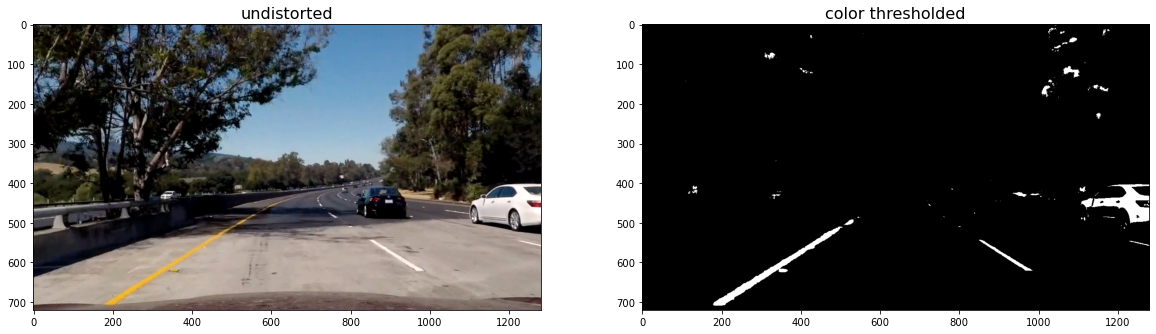

In [254]:
# Run the function
color_binary = col_thresh(undistorted)

# Plot the result
plt_images(undistorted, 'undistorted', color_binary, 'color thresholded')

#### 2.2.5: Combine all the thresholds to identify the lane lines

In [255]:
def combine_threshold(grad_x, grad_y, mag_binary, dir_binary, color_binary):
    # Combine all the thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1) ] = 1
    return combined_binary

#### Example Thresholded Binary Image - Combine Threshold

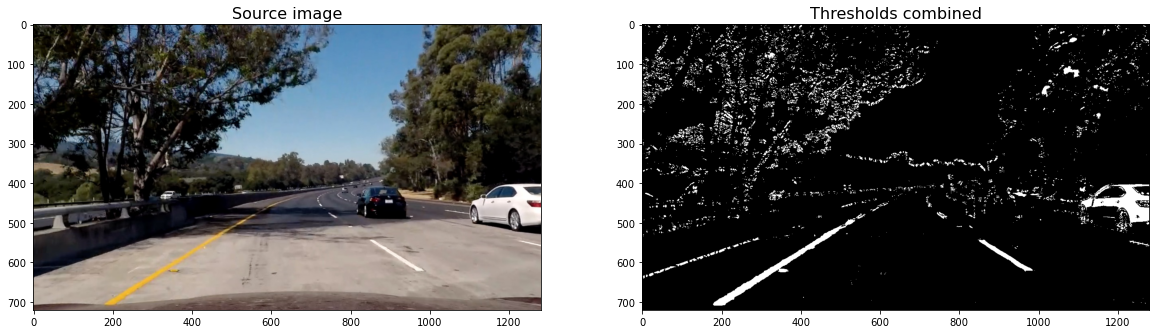

In [256]:
# Run the function
combined = combine_threshold(grad_x, grad_y, mag_binary, dir_binary, color_binary)

# Plot the result
plt_images(undistorted, 'Source image', combined, 'Thresholds combined')

### Step 2.3: Apply a perspective transform to rectify binary image ("birds-eye view")

In [257]:
# Define perspective transform function
def warp_transform(img, src_coordinates=None, dst_coordinates=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right
    
    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

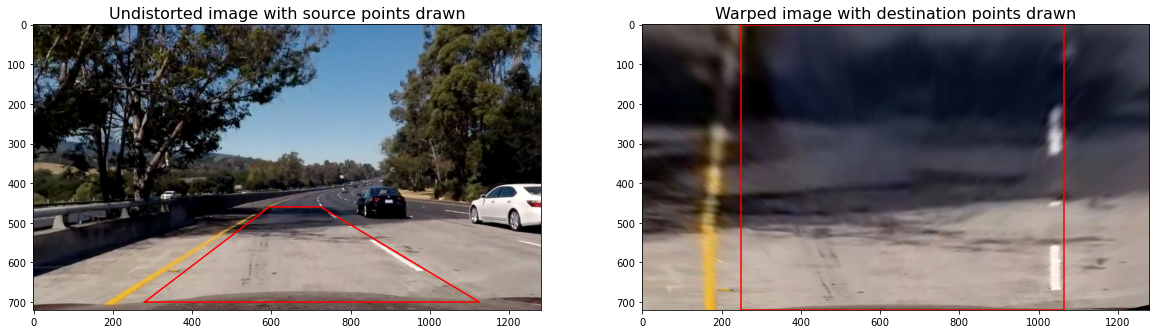

In [258]:
# Run the function
warped_img, _ , Minv  = warp_transform(undistorted)
src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(undistorted)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

plt.savefig("./writeup_images/warped_image.jpg")

### Step 2.4: Detect lane pixels and fit to find the lane boundary.

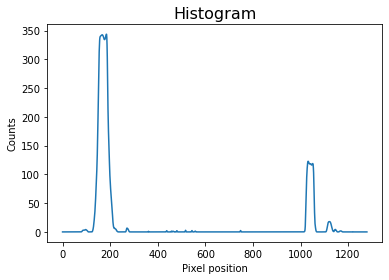

In [259]:
def get_histogram(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]  # Take bottom rows

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)

    return histogram

# Run de function over the combined warped image
combined_warped = warp_transform(combined)[0]
histogram = get_histogram(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

# Save for Writeup
plt.savefig("./writeup_images/histogram.jpg")

In [260]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    try:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        return ((None, None), (None, None), (None, None), None)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

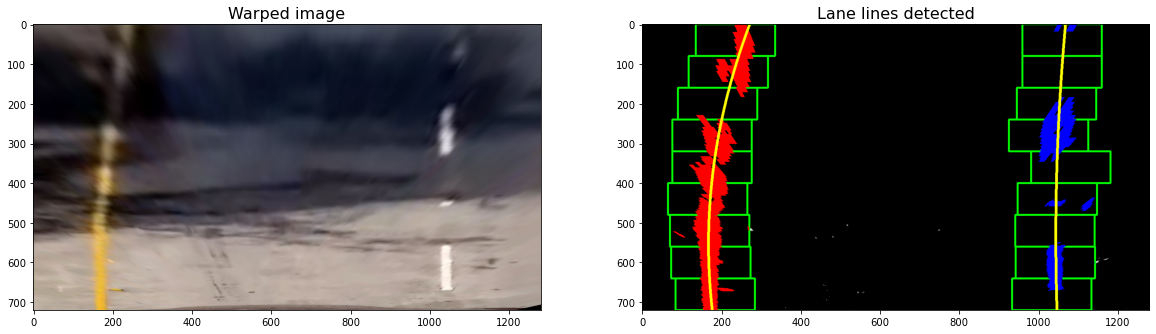

In [261]:
# Run the function
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)

# Plot the results
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

In [262]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

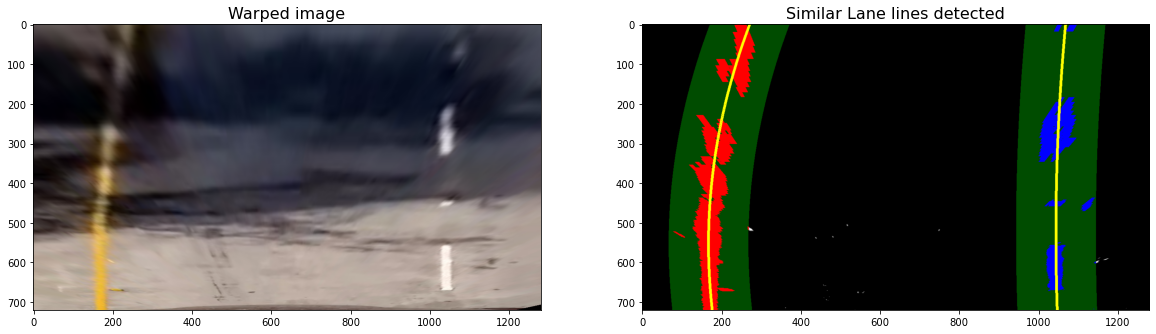

In [263]:
# Run the function
# Notice I am passing the same image than before.
# In a video stream, it should be passed the next frame.
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)

# Plot the results
plt_images(warped_img, 'Warped image', out_img, 'Similar Lane lines detected')

### Step 2.5: Determine the curvature of the lane and vehicle position with respect to center.

In [264]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    # ym_per_pix = 25/720 # meters per pixel in y dimension
    # xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty) # Radius of curvature at max y (bottom of the image . close to our vehicle)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [265]:
# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 385.1003368762981 m
Right line curvature: 1482.089602410294 m


In [266]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [267]:
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: 0.13121695683934403 m.


### Step 2.6: Warp the detected lane boundaries back onto the original image.

In [268]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

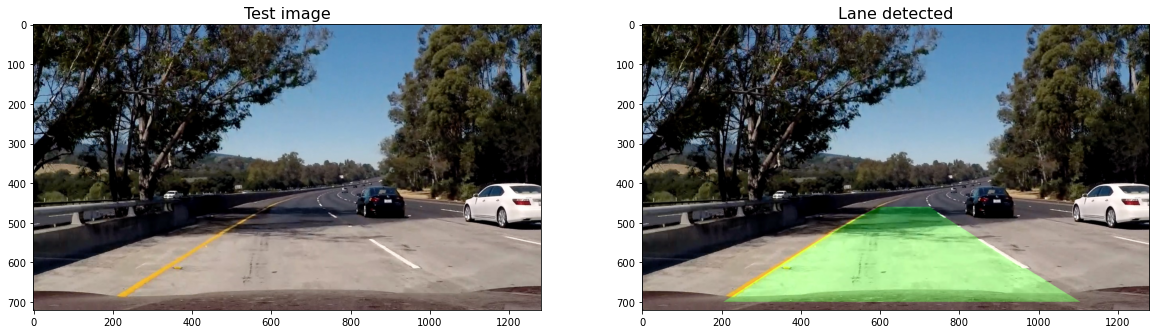

In [269]:
# Run the function
img_lane = draw_lane(image, combined_warped, left_points, right_points, Minv)

# Plot the results
plt_images(image, 'Test image', img_lane, 'Lane detected')


### Step 2.7: Display lane boundaries and numerical estimation of lane curvature and vehicle position.


In [270]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

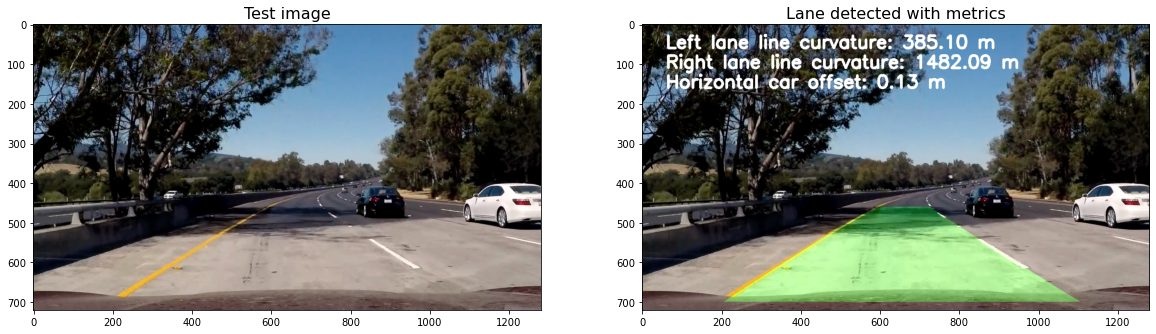

In [271]:
# Run the function
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the results
plt_images(image, 'Test image', out_img, 'Lane detected with metrics')

### 2.8 Define a class to receive the characteristics of each line detection

In [272]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### 2.9 Sanity Checks: Similar Radius of Curvature, Right Horizontal Distance, Roughly Parallel

In [274]:
def do_sanity_check(img, left_line, left_fitx, left_fit, right_line, right_fitx, right_fit):
    (h, w) = img.shape
    x1_diff = 0
    x2_diff = 0
    x3_diff = 0
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Right Horizontal Distance at three y-points
    y1 = int(0.9 * h) # Bottom
    y2 = int(0.6 * h) # Middle
    y3 = int(0.3 * h) # Top
    
    if left_fit is not None and right_fit is not None:
    
        # Compute the respective x-values for both lines
        x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
        x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
        x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

        x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
        x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
        x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

        # Compute the L1 norms
        x1_diff = abs(x1l - x1r)
        x2_diff = abs(x2l - x2r)
        x3_diff = abs(x3l - x3r)
        
    else:
        
        left_line.detected=False
        right_line.detected=False
        
        return (left_line.bestx, right_line.bestx), (x1_diff, x2_diff, x3_diff)

    # Define the threshold values for each of the three points
    if ((500 < x1_diff < 970) and ((500 < x2_diff < 970) and (500 < x3_diff < 970))) and \
    (left_fitx is not None and right_fitx is not None) and \
    (len(left_fitx) > 10 and len(right_fitx) > 10):
        # Update the left_line and right_line Class object parameters
        left_line.detected = True
        right_line.detected = True
        
        # Sanity check for the line
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit

        #Keep a running average over 3 frames
        if len(left_line.recent_xfitted) > 3 and left_line.recent_xfitted:
            left_line.recent_xfitted.pop(0) # Remove the first one from List
            left_line.recent_fits.pop(0)

        left_line.recent_xfitted.append(left_fitx)
        left_line.recent_fits.append(left_fit)
        
        if len(left_line.recent_xfitted) > 1:
            left_line.bestx = np.mean(np.vstack(left_line.recent_xfitted),axis=0)
            left_line.best_fit = np.mean(np.vstack(left_line.recent_fits),axis=0)
                      
        #Keep a running average over 3 frames
        if len(right_line.recent_xfitted) > 3 and right_line.recent_xfitted:
            right_line.recent_xfitted.pop(0)
            right_line.recent_fits.pop(0)

        right_line.recent_xfitted.append(right_fitx)
        right_line.recent_fits.append(right_fit)

        if len(left_line.recent_xfitted) > 1:
            right_line.bestx = np.mean(np.vstack(right_line.recent_xfitted),axis=0)
            right_line.best_fit = np.mean(np.vstack(right_line.recent_fits),axis=0)

        return (left_fitx, right_fitx), (x1_diff, x2_diff, x3_diff)

    else:
        left_line.detected=False
        right_line.detected=False
        
        return (left_line.bestx, right_line.bestx), (x1_diff, x2_diff, x3_diff)
        

## 3: Run pipeline in a video.

In [275]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None
        self.left_line = Line()
        self.right_line = Line()

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)
        
        # Calculate Sobel gradient in x-direction 
        grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))
        
        # Calculate Sobel gradient in y-direction
        grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = mag_threshold(img, sobel_kernel=15, thresh=(50, 100))

        # Calculate gradient direction
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        col_binary = col_thresh(img)

        # Combine all the thresholds to identify the lane lines
        combined = combine_threshold(grad_x, grad_y, mag_binary, dir_binary, col_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   
        
        # Apply a perspective transform to rectify binary image ("birds-eye view") 
        combined_warped, _, Minv = warp_transform(combined, src_coordinates, dst_coordinates)
        
        # Create an output image to draw on and  visualize the result
        out_img_CW = np.dstack((combined_warped, combined_warped, combined_warped))*255
        
        if self.left_line.detected and self.right_line.detected:
            (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img = \
            detect_similar_lines(combined_warped, self.lines_fit, return_img=True)
        else:
            (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img = \
            detect_lines(combined_warped, return_img=True)
            
        # Santiy Checks
        (left_fitx, right_fitx), (x1_diff, x2_diff, x3_diff) = do_sanity_check(combined_warped, self.left_line, left_fitx, left_fit, \
                                    self.right_line, right_fitx, right_fit)

        # Warp the detected lane boundaries back onto the original image.
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
        if left_fitx is not None:
            img_lane = draw_lane(img, combined_warped, (left_fitx, ploty), (right_fitx, ploty), Minv)
            
            # Add metrics to the output img
            out_img = add_metrics(img_lane, leftx=left_fitx, rightx=right_fitx)
        else:
            out_img = img
        '''
        # Display Debug info
        out_img2 = out_img1.copy()
        cv2.putText(out_img2, 'B M T: {:.2f} {:.2f} {:.2f}'.format(x1_diff, x2_diff, x3_diff), 
                (60, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
        
        ret1 = np.hstack([img, out_img_CW])
        ret2 = np.hstack([out_img, out_img2])
        
        out_img = np.vstack([ret1, ret2])
        '''
                    
        return out_img

In [276]:
input_video = './project_video.mp4'
output_video = './project_video_output.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(30,42)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.



                                                                                                                    
t:  28%|██████████████████▉                                                | 137/485 [52:09<01:29,  3.87it/s, now=None]
                                                                                                                    
t:  28%|██████████████████▉                                                | 137/485 [52:09<01:29,  3.87it/s, now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



                                                                                                                       
                                                                                                                    
t:  28%|██████████████████▉                                                | 137/485 [57:17<01:29,  3.87it/s, now=None]
                                                                                                                    
t:  28%|██████████████████▉                                                | 137/485 [57:17<01:29,  3.87it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
Wall time: 5min 7s


In [277]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [278]:
input_video = './challenge_video.mp4'
output_video = './challenge_video_output.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(20,42)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.



                                                                                                                    
t:  28%|██████████████████▎                                              | 137/485 [1:00:16<01:29,  3.87it/s, now=None]
                                                                                                                    
t:  28%|██████████████████▎                                              | 137/485 [1:00:16<01:29,  3.87it/s, now=None]

Moviepy - Building video ./challenge_video_output.mp4.
Moviepy - Writing video ./challenge_video_output.mp4



                                                                                                                       
                                                                                                                    
t:  28%|██████████████████▎                                              | 137/485 [1:02:13<01:29,  3.87it/s, now=None]
                                                                                                                    
t:  28%|██████████████████▎                                              | 137/485 [1:02:13<01:29,  3.87it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./challenge_video_output.mp4
Wall time: 1min 57s


In [279]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))